The goal here is to identify a good core set of features to use in other tasks, like clustering, decision trees, and neural networks. It would be possible to group all proposed features together, even using an automated process such as feature agglomeration. However, this offends our sensibilities that features should be interpretable. What can we do to get a picture of what features are useful? Or even how many features to choose? This is a rough, exploratory procedure, but it gives us a starting point.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import sys
sys.path.append('/depot/tdm-musafe/apps')
from make_features import load_data

%matplotlib widget

In [2]:
incidents, acceleration = load_data(drop_batches = False)

In [3]:
features = pd.read_csv('/depot/tdm-musafe/data/features.csv', index_col = 'incident_id').loc[incidents.index]

First, rescale each feature to have zero mean and unit variance. Then, find the eigenvalues of the covariance matrix.

In [4]:
from sklearn.preprocessing import StandardScaler
f = StandardScaler().fit_transform(features)
w = np.linalg.eigvals(np.cov(f.T))

There is a rule of thumb that the number of features we should keep is related to the number of eigenvalues greater than 1. We can make a so-called "scree plot" showing the distribution of eigenvalues.

In [5]:
components = (w > 1).sum()
components

18

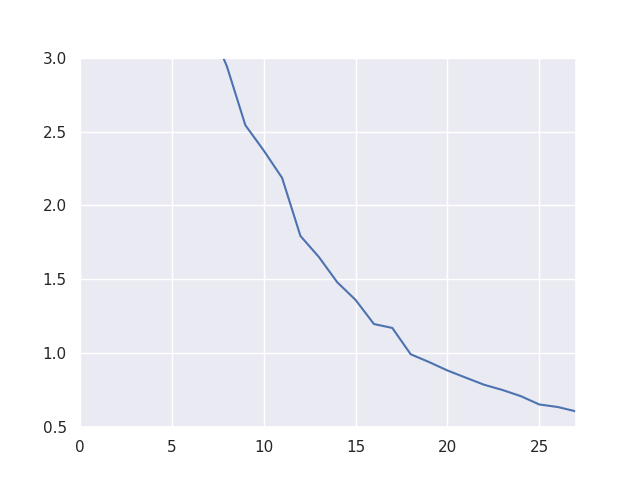

In [6]:
fig, ax = plt.subplots()
ax.plot(w)
ax.set_xlim(xmin = 0, xmax=components*1.5)
ax.set_ylim(ymin = 0.5, ymax=3)
plt.show()

The scree plot does not show a clear delineation, but the transition from >1 to <1 seems as good as any for where to draw the line. We can use that as a number of components to seek out using factor analysis,

In [7]:
from sklearn.decomposition import FactorAnalysis

In [8]:
fact = FactorAnalysis(n_components = components, rotation='varimax').fit(f)

To make it easier to distinguish the factors, let's scale them so their largest component is 1, changing sign if necessary.

In [9]:
scale = np.diag(fact.components_.T[abs(fact.components_).argmax(axis=1)])
loadings = pd.DataFrame((fact.components_.T / scale).T, columns = features.columns)

In [10]:
with pd.option_context("display.max_columns", None):
    display(loadings.style.background_gradient(axis='columns', cmap = 'RdYlGn', vmin=-1, vmax=1))

,maximum,minimum,mean,variance,skew,kurtosis,mean x,mean y,mean z,peak x,peak y,peak z,stillness,middle of stillness,angular path length,biggest angle difference,angle between incident and vertical,low frequency power,medium frequency power,high frequency power,window 0:5000 maximum,window 0:5000 minimum,window 0:5000 mean,window 0:5000 variance,window 0:5000 skew,window 0:5000 kurtosis,window 0:5000 mean x,window 0:5000 mean y,window 0:5000 mean z,window 0:5000 angular path length,window 0:5000 biggest angle difference,window 0:5000 low frequency power,window 0:5000 medium frequency power,window 0:5000 high frequency power,window 2500:7500 maximum,window 2500:7500 minimum,window 2500:7500 mean,window 2500:7500 variance,window 2500:7500 skew,window 2500:7500 kurtosis,window 2500:7500 mean x,window 2500:7500 mean y,window 2500:7500 mean z,window 2500:7500 angular path length,window 2500:7500 biggest angle difference,window 2500:7500 low frequency power,window 2500:7500 medium frequency power,window 2500:7500 high frequency power,window 5000:10000 maximum,window 5000:10000 minimum,window 5000:10000 mean,window 5000:10000 variance,window 5000:10000 skew,window 5000:10000 kurtosis,window 5000:10000 mean x,window 5000:10000 mean y,window 5000:10000 mean z,window 5000:10000 angular path length,window 5000:10000 biggest angle difference,window 5000:10000 low frequency power,window 5000:10000 medium frequency power,window 5000:10000 high frequency power,window 7500:12500 maximum,window 7500:12500 minimum,window 7500:12500 mean,window 7500:12500 variance,window 7500:12500 skew,window 7500:12500 kurtosis,window 7500:12500 mean x,window 7500:12500 mean y,window 7500:12500 mean z,window 7500:12500 angular path length,window 7500:12500 biggest angle difference,window 7500:12500 low frequency power,window 7500:12500 medium frequency power,window 7500:12500 high frequency power,window 10000:15000 maximum,window 10000:15000 minimum,window 10000:15000 mean,window 10000:15000 variance,window 10000:15000 skew,window 10000:15000 kurtosis,window 10000:15000 mean x,window 10000:15000 mean y,window 10000:15000 mean z,window 10000:15000 angular path length,window 10000:15000 biggest angle difference,window 10000:15000 low frequency power,window 10000:15000 medium frequency power,window 10000:15000 high frequency power
0,0.013789,-0.040942,-0.041755,-0.012299,0.026187,0.017072,0.049702,-0.036798,0.074345,0.128901,-0.041353,-0.094905,-0.105443,0.020957,0.775108,0.670591,0.109886,0.071520,-0.071100,0.008733,-0.045494,0.042510,-0.050315,-0.053327,-0.012624,0.025388,0.003202,-0.044424,0.087118,0.292351,0.232132,0.023057,-0.064747,-0.044766,0.003391,-0.063475,-0.038081,-0.006730,0.002754,0.041822,0.005916,-0.073173,0.098958,0.804291,0.759069,0.069896,-0.040091,-0.002977,0.011735,-0.059899,-0.021154,0.014299,-0.012844,-0.018722,0.072238,-0.073902,0.064304,1.000000,0.948937,0.051536,-0.082716,0.024776,0.012537,0.012323,-0.022568,-0.004995,0.080576,0.076181,0.082416,-0.027029,0.033654,0.727542,0.664274,0.062285,-0.044221,-0.019756,-0.041952,0.038103,-0.042476,-0.040005,-0.034984,0.044016,0.053378,0.012170,0.037977,0.342832,0.323239,-0.004446,-0.045353,-0.048075
1,0.012796,0.027912,-0.122904,0.037767,0.053479,0.027672,0.170448,1.000000,0.179553,0.035192,0.845023,0.095868,0.016472,-0.011285,-0.050482,-0.067768,-0.038519,0.007108,-0.006352,-0.070319,-0.097024,0.040548,-0.245830,-0.054626,-0.018582,-0.026291,0.087886,0.978252,0.132403,-0.037687,-0.035340,-0.033084,-0.032502,-0.097011,-0.012090,0.046671,-0.142727,-0.019989,0.064123,0.053275,0.097747,0.983689,0.167111,-0.056854,-0.053004,-0.059194,-0.037994,-0.085846,0.012117,0.003752,-0.017092,0.057579,0.017651,0.002040,0.169981,0.984993,0.185692,-0.059593,-0.098579,0.018756,0.065351,0.009237,0.010953,-0.010163,-0.026187,0.061558,-0.006984,-0.017301,0.220864,0.982824,0.175760,-0.023003,-0.001220,0.033619,0.070816,0.014628,-0.043150,0.013649,-0.126663,0.006196,0.002762,-0.052112,0.182419,0.975430,0.142115,0.011921,

Before devoting work to the interpretation of these factor loadings, we should save this and continue in another document. That way, should a change in the features occur, the results will stilll be interpretable.

In [11]:
loadings.to_csv('factor_loadings.csv')